# Кардиотокография

## Постановка задачи

Кардиотокография — диагностическая техника, фиксирующая сердцебиение плода и тонус матки и позволяющая оценить состояние эмбриона. Непосредственный результат наблюдений интерпретировать крайне сложно. Чтобы облегчить задачу диагностики, результаты кардиотокографии 1831 эмбрионов были классифицированы опытными специалистами на нормальные и патологические, а на основе показаний прибора был сгенерирован 21 признак. Ставится задача построения функции, определяющей вероятность наличия патологии по описанию кардиотокограммы и оценки вклада признаков.

## Решение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.distributions import chi2
%matplotlib inline

In [2]:
data = pd.read_csv('CTG.csv', sep=',')

Посмотрим на распределения непрерывных признаков в классах:

In [3]:
data_P = data[data.NSP =='P'].drop(columns=['NSP','DS', 'DR', 'Tendency'])
data_X = data[data.NSP =='N'].drop(columns=['NSP','DS', 'DR', 'Tendency'])

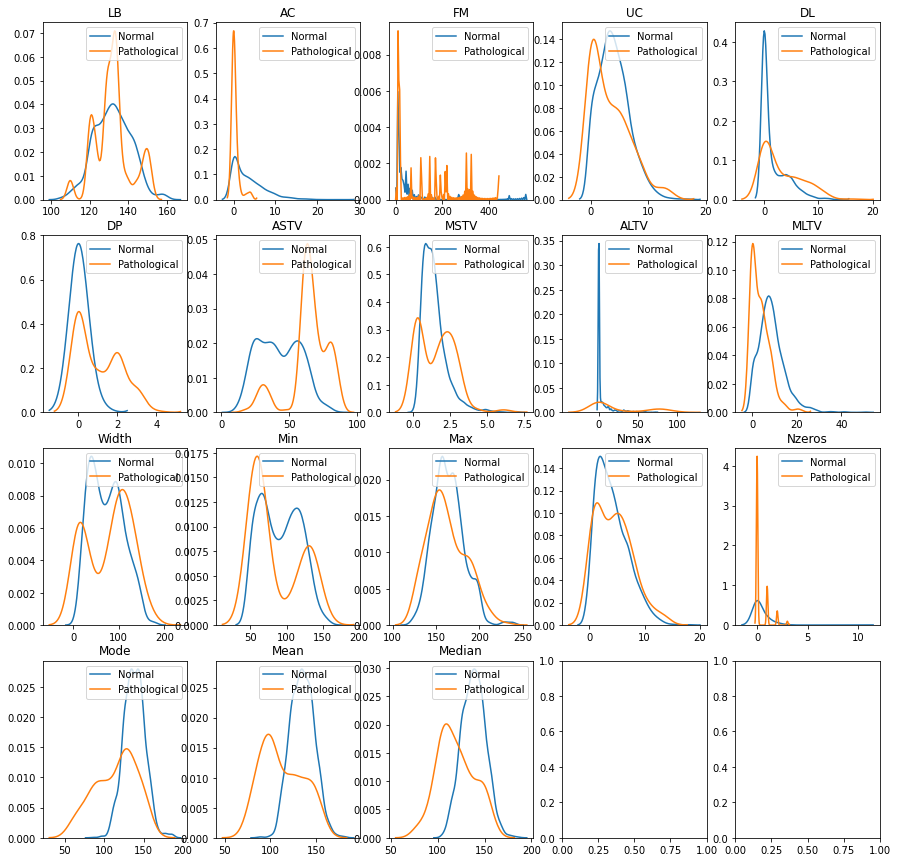

In [4]:
fig, ax = plt.subplots(4, 5, figsize=(15,15))
ax = ax.ravel() 

for idx in range(len(data_X.columns)):
    try:
        sns.kdeplot(data_X.iloc[:,idx], ax = ax[idx])
    except:
        sns.kdeplot(data_X.iloc[:,idx], ax = ax[idx], bw = 0.5)
    try:
        sns.kdeplot(data_P.iloc[:,idx], ax = ax[idx])
    except:
        sns.kdeplot(data_P.iloc[:,idx], ax = ax[idx], bw = 0.5)
    ax[idx].set_title(data_X.columns[idx])
    ax[idx].legend(('Normal', 'Pathological'),loc='upper right')

Линейной разделимости по отдельным признакам нет.

Посмотрим на таблицы сопряжённости по категориальным признакам:

In [5]:
pd.crosstab(data.DS, data.NSP)

NSP,N,P
DS,,
0,1654,170
1,1,6


In [6]:
pd.crosstab(data.DR, data.NSP)

NSP,N,P
DR,,
0,1655,176


In [7]:
pd.crosstab(data.Tendency, data.NSP)

NSP,N,P
Tendency,,
-1,101,49
0,887,91
1,667,36


DR — константа, DS — почти константа, поэтому удалим эти признаки.

In [8]:
data = data.drop(columns = ['DR', 'DS'])

Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [9]:
data["NSP"] = (data["NSP"] == "P").astype(int)

In [10]:
m0 = smf.glm('NSP ~ 1',
             data, family=sm.families.Binomial())
result_m0 = m0.fit()

In [11]:
#likelihood ratio
def lrtest(lmin, lmax):
    return(2*(lmax-lmin))

In [12]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in data.drop(columns = ['NSP']).columns:
    formula = 'NSP ~ 1 +' + i
    model = sm.formula.glm(formula,
                           family=sm.families.Binomial(), 
                           data=data).fit()
    lr = lrtest(result_m0.llf, model.llf)
    Single_term = Single_term.append({'features': i, 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

,features,p-val
0,LB,0.694
1,AC,0.000
2,FM,0.009
3,UC,0.001
4,DL,0.000
5,DP,0.000
6,ASTV,0.000
7,MSTV,0.041
8,ALTV,0.000
9,MLTV,0.000


## Модель 1
Многомерная модель со всеми предикторами, значимыми на уровне 0.25:

In [13]:
data = data.drop(columns=['LB', 'Nzeros'])

In [14]:
data['const'] = [1] * data.shape[0]
data['Tendency1']=1*(data.Tendency==1)
data['Tendency-1']=1*(data.Tendency==-1)
tendency = data['Tendency']
data = data.drop(columns = ['Tendency'])

In [15]:
m1 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m1 = m1.fit()
result_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84.573
Date:                Sat, 18 Apr 2020   Deviance:                       169.15
Time:                        15:55:15   Pearson chi2:                 1.62e+03
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.6081      0.413     -3.894      0.000      -2.418      -0.799
FM             0.0138      0.006      2.343      0.019       0.002       0.025
UC            -0.6939      0.114     -6.076      0.000      -0.918      -0.470
DL             0.1436      0.120      1.198      0.231      -0.091       0.378
DP             4.7699      0.678      7.033      0.000       3.441       6.099
ASTV           0.1406      0.021      6.642      0.000       0.099       0.182
MSTV           0.4087      0.422      0.970      0.332      -0.417       1.235
ALTV           0.0767      0.013      5.706      0.000       0.050       0.103
MLTV          -0.0180      0.065     -0.277      0.782      -0.145       0.109
Width          0.0380      0.009      4.323      0.000       0.021       0.055
Min            0.0370      0.014      2.576      0.010       0.009       0.065
Max            0.0750      0.017      4.534      0.000       0.043       0.107
Nmax          -0.5866      0.169     -3.470      0.001      -0.918      -0.255
Mode          -0.1048      0.030     -3.457      0.001      -0.164      -0.045
Mean           0.0343      0.047      0.736      0.462      -0.057       0.126
Median        -0.1008      0.047     -2.132      0.033      -0.193      -0.008
const         -4.4965      3.387     -1.328      0.184     -11.135       2.142
Tendency1      1.8618      0.634      2.939      0.003       0.620       3.104
Tendency-1    -2.0489      0.813     -2.522      0.012      -3.641      -0.456
==============================================================================
"""

Проверим признаки на коллинеарность. Для этого подсчитаем коэффициент VIF(variance inflation factor):

In [16]:
VIF = pd.DataFrame(columns=['features', 'VIF Factor'])
variables = result_m1.model.exog
for i in range(variables.shape[1]):
    VIF = VIF.append({'features':result_m1.params.index[i] , 'VIF Factor': variance_inflation_factor(variables, i)}, ignore_index=True)
VIF

/opt/hostedtoolcache/Python/3.7.6/x64/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,AC,1.844564
1,FM,1.092199
2,UC,1.296282
3,DL,2.480005
4,DP,1.683562
5,ASTV,1.599821
6,MSTV,2.489409
7,ALTV,1.530505
8,MLTV,1.668546
9,Width,inf


По всей видимости, коллинеарны признаки в группе Width, Min и Max. Удалим, к примеру, Width.

## Модель 2

Попробуем улучшить результат. 

In [17]:
data = data.drop(columns = ['Width'])

In [18]:
m2 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m2 = m2.fit()
result_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84.573
Date:                Sat, 18 Apr 2020   Deviance:                       169.15
Time:                        15:55:15   Pearson chi2:                 1.62e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.6081      0.413     -3.894      0.000      -2.418      -0.799
FM             0.0138      0.006      2.343      0.019       0.002       0.025
UC            -0.6939      0.114     -6.076      0.000      -0.918      -0.470
DL             0.1436      0.120      1.198      0.231      -0.091       0.378
DP             4.7699      0.678      7.033      0.000       3.441       6.099
ASTV           0.1406      0.021      6.642      0.000       0.099       0.182
MSTV           0.4087      0.422      0.970      0.332      -0.417       1.235
ALTV           0.0767      0.013      5.706      0.000       0.050       0.103
MLTV          -0.0180      0.065     -0.277      0.782      -0.145       0.109
Min           -0.0010      0.017     -0.059      0.953      -0.035       0.033
Max            0.1129      0.022      5.076      0.000       0.069       0.157
Nmax          -0.5866      0.169     -3.470      0.001      -0.918      -0.255
Mode          -0.1048      0.030     -3.457      0.001      -0.164      -0.045
Mean           0.0343      0.047      0.736      0.462      -0.057       0.126
Median        -0.1008      0.047     -2.132      0.033      -0.193      -0.008
const         -4.4965      3.387     -1.328      0.184     -11.135       2.142
Tendency1      1.8618      0.634      2.939      0.003       0.620       3.104
Tendency-1    -2.0489      0.813     -2.522      0.012      -3.641      -0.456
==============================================================================
"""

Критерий отношения правдоподобия считает такую модель существенно лучше константы (то есть объясняемая переменная действительно зависит от выбранных факторов, в противном случае она бы лучше описывалась константой и случайной ошибкой):

In [19]:
lr = lrtest(result_m0.llf,result_m2.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


## Модели 3 и 4

Удалим незначимые признаки.

In [20]:
data = data.drop(columns=['FM', 'DL', 'MSTV', 'MLTV', 'Min', 'Mean',
                         'Median'])

In [21]:
m3 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m3 = m3.fit()
result_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1820
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.099
Date:                Sat, 18 Apr 2020   Deviance:                       180.20
Time:                        15:55:15   Pearson chi2:                 1.52e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.5260      0.363     -4.203      0.000      -2.238      -0.814
UC            -0.6544      0.107     -6.140      0.000      -0.863      -0.445
DP             5.2835      0.649      8.140      0.000       4.011       6.556
ASTV           0.1262      0.017      7.376      0.000       0.093       0.160
ALTV           0.0688      0.011      6.357      0.000       0.048       0.090
Max            0.0999      0.017      5.761      0.000       0.066       0.134
Nmax          -0.3516      0.123     -2.858      0.004      -0.593      -0.111
Mode          -0.1489      0.020     -7.478      0.000      -0.188      -0.110
const         -4.8045      2.445     -1.965      0.049      -9.597      -0.012
Tendency1      1.5226      0.522      2.915      0.004       0.499       2.546
Tendency-1    -1.9989      0.732     -2.732      0.006      -3.433      -0.565
==============================================================================
"""

In [22]:
lr = lrtest(result_m3.llf,result_m2.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.001


По критерию отношения правдоподобия ухудшения не произошло. В полученной модели значимы все признаки.

Попробуем добавлять в линейную модель попарные взаимодействия (при этом для простоты не будем брать взаимодействия с категориальным признаком).

In [23]:
from itertools import combinations
cc = list(combinations(data.drop(columns = ['NSP', 'Tendency1', 'Tendency-1', 'const']).columns, 2))
for c in cc:
    name_str = str(c).replace("'", "")
    data[name_str] = data[c[0]]*data[c[1]]

In [24]:
number_all_param = data.columns.get_loc('Tendency-1')

In [25]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in range(1,len(cc)):
    model = sm.GLM(data.NSP,  
                pd.concat([data.drop(columns='NSP').iloc[:, :number_all_param],
                           data.iloc[:, number_all_param+i]], 
                           axis=1),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(result_m3.llf, model.llf)
    Single_term = Single_term.append({'features': data.columns[number_all_param+i], 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

/opt/hostedtoolcache/Python/3.7.6/x64/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/hostedtoolcache/Python/3.7.6/x64/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/hostedtoolcache/Python/3.7.6/x64/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/opt/hostedtoolcache/Python/3.7.6/x64/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +


,features,p-val
0,"(AC, UC)",0.115
1,"(AC, DP)",0.318
2,"(AC, ASTV)",0.517
3,"(AC, ALTV)",NaN
4,"(AC, Max)",0.542
5,"(AC, Nmax)",0.420
6,"(AC, Mode)",0.348
7,"(UC, DP)",0.910
8,"(UC, ASTV)",0.000
9,"(UC, ALTV)",0.012


Получили несколько NaN в таблице. Посмотрим что содержится в данных показателя.

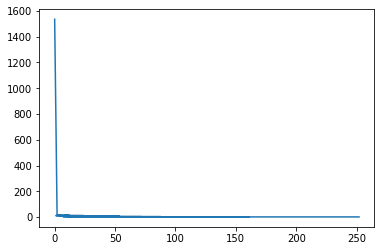

In [26]:
plt.plot(data['(AC, ALTV)'].value_counts())

Бинаризуем выборку, так как нулей намного больше, чем остальных значений. Пересчитаем таблицу. 

In [27]:
data.loc[data['(AC, ALTV)'] != 0, '(AC, ALTV)'] = 1

In [28]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in range(1,len(cc)):
    model = sm.GLM(data.NSP,  
                pd.concat([data.drop(columns='NSP').iloc[:, :number_all_param],
                           data.iloc[:, number_all_param+i]], 
                           axis=1),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(result_m3.llf, model.llf)
    Single_term = Single_term.append({'features': data.columns[number_all_param+i], 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

,features,p-val
0,"(AC, UC)",0.115
1,"(AC, DP)",0.318
2,"(AC, ASTV)",0.517
3,"(AC, ALTV)",0.083
4,"(AC, Max)",0.542
5,"(AC, Nmax)",0.420
6,"(AC, Mode)",0.348
7,"(UC, DP)",0.910
8,"(UC, ASTV)",0.000
9,"(UC, ALTV)",0.012


Попробуем добавить несколько наиболее значимых:

In [29]:
data.columns

Index(['AC', 'UC', 'DP', 'ASTV', 'ALTV', 'Max', 'Nmax', 'Mode', 'NSP', 'const',
       'Tendency1', 'Tendency-1', '(AC, UC)', '(AC, DP)', '(AC, ASTV)',
       '(AC, ALTV)', '(AC, Max)', '(AC, Nmax)', '(AC, Mode)', '(UC, DP)',
       '(UC, ASTV)', '(UC, ALTV)', '(UC, Max)', '(UC, Nmax)', '(UC, Mode)',
       '(DP, ASTV)', '(DP, ALTV)', '(DP, Max)', '(DP, Nmax)', '(DP, Mode)',
       '(ASTV, ALTV)', '(ASTV, Max)', '(ASTV, Nmax)', '(ASTV, Mode)',
       '(ALTV, Max)', '(ALTV, Nmax)', '(ALTV, Mode)', '(Max, Nmax)',
       '(Max, Mode)', '(Nmax, Mode)'],
      dtype='object')

In [30]:
data = data[['AC','UC','DP',
             'ASTV','ALTV',
             'Max','Nmax','Mode',
             'NSP','const',
             'Tendency1','Tendency-1',
             '(UC, ASTV)', '(DP, ASTV)', '(ASTV, Mode)']]

In [31]:
m4 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m4 = m4.fit()
result_m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1817
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77.505
Date:                Sat, 18 Apr 2020   Deviance:                       155.01
Time:                        15:55:17   Pearson chi2:                     801.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
AC              -1.4775      0.331     -4.469      0.000      -2.126      -0.830
UC               0.9331      0.421      2.217      0.027       0.108       1.758
DP               7.1570      1.817      3.938      0.000       3.595      10.719
ASTV             0.0987      0.175      0.564      0.572      -0.244       0.442
ALTV             0.0674      0.012      5.606      0.000       0.044       0.091
Max              0.0893      0.019      4.814      0.000       0.053       0.126
Nmax            -0.2372      0.132     -1.801      0.072      -0.495       0.021
Mode            -0.2005      0.080     -2.503      0.012      -0.358      -0.044
const           -2.6630     11.068     -0.241      0.810     -24.357      19.031
Tendency1        1.5050      0.589      2.557      0.011       0.351       2.659
Tendency-1      -1.9423      0.824     -2.356      0.018      -3.558      -0.327
(UC, ASTV)      -0.0244      0.007     -3.524      0.000      -0.038      -0.011
(DP, ASTV)      -0.0417      0.031     -1.366      0.172      -0.102       0.018
(ASTV, Mode)     0.0009      0.001      0.716      0.474      -0.002       0.003
================================================================================
"""

In [32]:
lr = lrtest(result_m3.llf,result_m4.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


По критерию отношения правдоподобия получается лучше, однако часть коэффициентов модели незначимы. Проверим, что можно безболезненно удалить:

In [33]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in data.drop(columns = ['NSP', 'const']).columns:
    model = sm.GLM(data.NSP, data.drop(columns=['NSP', i]),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(model.llf, result_m4.llf)
    Single_term = Single_term.append({'features': i, 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term.style.applymap(lambda x: 'background-color : yellow' if x>0.1
                           else '', subset=pd.IndexSlice[:, ['p-val']])

,features,p-val
0,AC,0.000000
1,UC,0.033000
2,DP,0.000000
3,ASTV,0.562000
4,ALTV,0.000000
5,Max,0.000000
6,Nmax,0.061000
7,Mode,0.008000
8,Tendency1,0.009000
9,Tendency-1,0.011000


Удалим DP ASTV, ASTV Mode и ASTV:

In [34]:
data = data.drop(columns = ['ASTV' , '(DP, ASTV)','(ASTV, Mode)'])
data = data.astype('float32')

In [35]:
m5 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m5 = m5.fit()
result_m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1820
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -131.09
Date:                Sat, 18 Apr 2020   Deviance:                       262.19
Time:                        15:55:17   Pearson chi2:                 2.20e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.5644      0.338     -4.625      0.000      -2.227      -0.901
UC            -1.3916      0.298     -4.673      0.000      -1.975      -0.808
DP             5.0496      0.575      8.789      0.000       3.923       6.176
ALTV           0.0775      0.008      9.343      0.000       0.061       0.094
Max            0.0934      0.015      6.287      0.000       0.064       0.122
Nmax          -0.4501      0.108     -4.175      0.000      -0.661      -0.239
Mode          -0.1273      0.015     -8.304      0.000      -0.157      -0.097
const          0.7000      1.813      0.386      0.699      -2.853       4.253
Tendency1      1.3800      0.424      3.253      0.001       0.548       2.212
Tendency-1    -1.1214      0.563     -1.991      0.047      -2.226      -0.017
(UC, ASTV)     0.0145      0.004      3.396      0.001       0.006       0.023
==============================================================================
"""

In [36]:
lr = lrtest(result_m5.llf,result_m4.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


In [37]:
lr = lrtest(result_m3.llf,result_m5.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 1.000


Модель получается не хуже пятой и лучше третьей; остановимся на ней.

## Модель 6

Попробуем удалить влиятельные наблюдения:

In [38]:
infl = result_m5.get_influence()
sm_fr = infl.summary_frame()

Text(0, 0.5, 'Cooks distance')

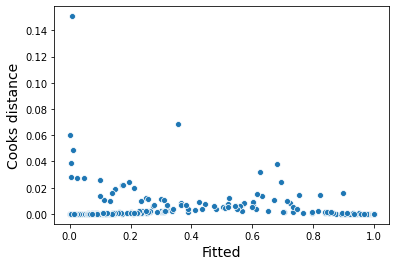

In [39]:
sns.scatterplot(result_m5.fittedvalues,sm_fr.cooks_d)
plt.xlabel('Fitted', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)

In [40]:
data_del = data[sm_fr.cooks_d <= 0.125]

In [41]:
m6 = sm.GLM(data_del.NSP, data_del.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m6 = m6.fit()
[result_m6.params,result_m5.params]

[AC           -1.585478
 UC           -1.772334
 DP            5.360947
 ALTV          0.078059
 Max           0.093928
 Nmax         -0.432599
 Mode         -0.125638
 const         0.467048
 Tendency1     1.256296
 Tendency-1   -1.130366
 (UC, ASTV)    0.019557
 dtype: float64,
 AC           -1.564403
 UC           -1.391554
 DP            5.049589
 ALTV          0.077540
 Max           0.093354
 Nmax         -0.450057
 Mode         -0.127258
 const         0.700023
 Tendency1     1.379985
 Tendency-1   -1.121413
 (UC, ASTV)    0.014463
 dtype: float64]

Различия небольшие, так что оставим модель, настроенную на полных данных.

## Итог
Посмотрим на качество классификации:

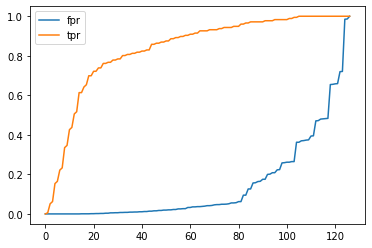

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
pred = np.asarray(m5.predict(result_m5.params))
real = np.asarray(data.NSP)
fpr, tpr, thresholds = roc_curve(real, pred)
plt.plot(fpr, label = 'fpr')
plt.plot(tpr, label = 'tpr')
plt.legend(fontsize=10)

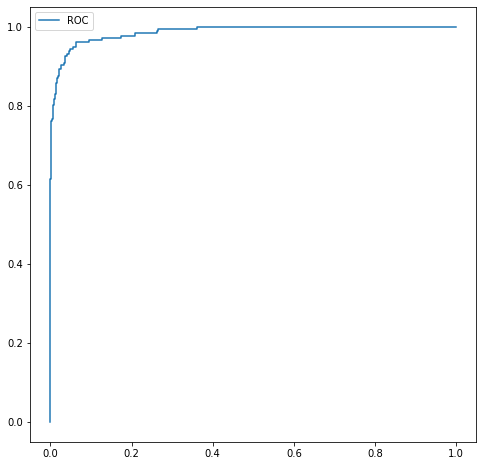

In [43]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.legend(fontsize=10)

In [44]:
roc_auc_score(real,pred)

0.986864872287833

In [45]:
lr = lrtest(result_m0.llf,result_m5.llf)
print('Likelihood Ratio Test Of Nested Models, p: %f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000000


Площадь под ROC-кривой составляет 0.986. 
Значимость модели по критерию отношения правдоподобия равна 0.00.

In [46]:
type(1/np.exp(result_m5.params)*np.sign(result_m5.params))

pandas.core.series.Series

In [47]:
df = (1/np.exp(result_m5.conf_int()))
df = pd.concat([df,1/np.exp(result_m5.params)*np.sign(result_m5.params)], axis = 1)
df.columns = ['low_conf', 'up_conf', 'params']
df

,low_conf,up_conf,params
AC,9.275192,2.463203,-4.779820
UC,7.208087,2.243204,-4.021095
DP,0.019772,0.002079,0.006412
ALTV,0.940566,0.910458,0.925390
Max,0.937769,0.884744,0.910871
Nmax,1.937405,1.269679,-1.568401
Mode,1.170340,1.102105,-1.135710
const,17.335715,0.014224,0.496574
Tendency1,0.577845,0.109534,0.251582
Tendency-1,9.258958,1.017384,-3.069188


Расшифровки обозначений для признаков в финальной модели:

- AC - число ускорений в секунду;
- UC - число сокращений матки;
- DP - число длительных замедлений в секунду;
- ALTV - процент абнормальных долгосрочных изменений;
- ASTV - процент абнормальных краткосрочных изменений;
- Max - максимум гистограммы FHR;
- Nmax - число раз, которое достигается максимум в гистограмме FHR;
- Mode - мода гистограммы FHR
- Tendency - тенденция гистограммы FHR: -1 = левая асимметричный; 0 = симметричная; 1 = правая асимметричная.

Выводы:

* С ростом числа ускорений в секунду на единицу риск патологии уменьшается в 4.780 раз [9.275, 2.463].

* С увеличением на единицу числа длительных замедлений в секунду риск патологии увеличивается в 5.049 раз [0.019,0.002].

* Увеличение на процент доли абнормальных долгосрочных изменений связано с ростом риска патологии в 0.925 раз [0.94, 0.91].

* С увеличением на единицу максимума гистограммы FHR риск патологии увеличивается в 0.91 раз [1.937, 1.269].

* C каждым дополнительным максимумом гистограммы FHR риск патологии уменьшается в  1.568 раз [1.937, 1.269].

* Увеличение на единицу моды гистограммы FHR связано с уменьшением риска патологии в 1.135 раз [1.170, 1.102].

* При наличии левой ассиметрии гистограммы FHR риск патологии уменьшается в 3.069 раз [9.258, 1.017]

* При наличии правой ассиметрии гистограммы FHR риск патологии увеличивается в 0.251 раз [0.57, 0.109]

* Увеличение на процент доли абнормальных краткосрочных изменений при минимальном значении числа сокращений матки 0 связано с
увеличением риска патологии в 0.985 раз [0.993, 0.977].


Все приведённые доверительные интервалы построены на уровне доверия 95%.